# WHAT IF
### using the RWR on functionally-based adjacencies

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it 
import sklearn
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize

import pandas as pd
import pickle
import plotly
import plotly.graph_objs as pgo
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio

import seaborn as sns
import umap

%matplotlib inline

--- 
# FUNCTIONS 

In [2]:
# -------------------------------------
# the original function by Felix: 
# -------------------------------------

'''
Random Walk Operator with restart probability.
Return Matrix.
''' 
def rnd_walk_matrix2(A, r, a, num_nodes):

    num = 1*num_nodes
    n = num_nodes
    factor = float((1-a)/n) # = 0 if alpha = 1.0 

    E = np.multiply(factor,np.ones([n,n]))              # prepare 2nd scaling term
    A_tele = np.multiply(a,A) + E  #     print(A_tele)
    M = normalize(A_tele, norm='l1', axis=0)                                 # column wise normalized MArkov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)   

    return W


# -------------------------------------
# rwr modified (as used in this script) 
# -------------------------------------

def rwr_matrix(A, r): 
    n = len(A) # take the whole network into account = all nodes are seed nodes
    factor = 1 
    a = 1 # maximum freedom to jump anytime to any node within the network
    
    E = np.multiply(factor,np.ones([n,n])) # Matrix with all 1 --> to 
    A_tele = np.multiply(a,A) + E  #     print(A_tele)
    M = normalize(A_tele, norm='l1', axis=0)                                 # column wise normalized MArkov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)   

    return W


# -------------------------------------
# rwr simulated (just for testing, output = path from random walker)
# -------------------------------------

def random_walk_simple(start_v, number_of_steps):

    for step in range(1, number_of_steps):

        start_vertex = start_v # index of vertex to start from
        visited_vertices = {} # Dictionary that associate nodes with the amount of times it was visited   

        path = [start_vertex] # Store and print path  

        counter = 0 # Restart the cycle
        for counter in range(1, number_of_steps): 
            vertex_neighbors = [n for n in G.neighbors(start_vertex)] # get adjacent nodes
            probability = [] # Set probability of going to a neighbour is uniform
            probability = probability + [1./len(vertex_neighbors)] * len(vertex_neighbors)

            start_vertex = np.random.choice(vertex_neighbors, p=probability) # Choose a vertex from the vertex neighborhood to start the next random walk

            if start_vertex in visited_vertices: # Accumulate the amount of times each vertex is visited
                visited_vertices[start_vertex] += 1
            else:
                visited_vertices[start_vertex] = 1

            path.append(start_vertex) # Append to path

        # mostvisited = sorted(visited_vertices, key = visited_vertices.get,reverse = True) # Organize the vertex list in most visited decrescent order
        # print("Path: ", path)
        # print("Most visited nodes: ", mostvisited[:10]) # Separate the top 10 most visited vertex
        
        return path

    
# -------------------------------------
# plotting functions 
# -------------------------------------   

def draw_node_degree(G, scalef):
    #x = 20
    #ring_frac = np.sqrt((x-1.)/x)
    #ring_frac = (x-1.)/x

    l_size = {}
    for node in G.nodes():
        k = nx.degree(G, node)
        R = scalef * (1 + k**1.1) 

        l_size[node] = R
        
    return l_size

def draw_node_degree_3D(G, scalef):
    x = 3
    ring_frac = (x-1.)/x

    deg = dict(G.degree())
    
    d_size = {}
    for i in G.nodes():
        for k,v in deg.items():
            if i == k:
                R = scalef * (1+v**0.9)
                r = ring_frac * R
                d_size[i] = R
    
    return d_size 

def embed_umap_2D(Matrix, n_neighbors, spread, min_dist, metric='cosine'):
    n_components = 2 # for 2D

    U = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric)
    embed = U.fit_transform(Matrix)
    
    return embed


def get_posG_2D(l_nodes, embed):
    posG = {}
    cc = 0
    for entz in l_nodes:
        # posG[str(entz)] = (embed[cc,0],embed[cc,1])
        posG[entz] = (embed[cc,0],embed[cc,1])
        cc += 1

    return posG


def get_posG_3D(l_genes, embed):
    posG = {}
    cc = 0
    for entz in l_genes:
        posG[entz] = (embed[cc,0],embed[cc,1],embed[cc,2])
        cc += 1
    
    return posG

def color_nodes_from_dict(G, d_to_be_coloured, color_method):

    # Colouring
    colour_groups = set(d_to_be_coloured.values())
    colour_count = len(colour_groups)
    pal = sns.color_palette('YlOrRd', colour_count)
    palette = pal.as_hex()

    d_colourgroups = {}
    for n in colour_groups:
        d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
        
    d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

    d_val_col = {}
    for idx,val in enumerate(d_colourgroups_sorted):
        for ix,v in enumerate(palette):
            if idx == ix:
                d_val_col[val] = v

    d_node_colour = {}
    for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
        for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
            if x[0] == y[1]:
                d_node_colour[y[0]]=x[1]

    # SORT dict based on G.nodes
    d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])
    l_col = list(d_node_colour_sorted.values())
    colours = l_col
    
    return colours

def embed_umap_3D(Matrix, n_neighbors, spread, min_dist, metric='cosine'):
    n_components = 3 # for 3D

    U_3d = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric)
    embed = U_3d.fit_transform(Matrix)
    
    return embed

def get_posG_3D(l_genes, embed):
    posG = {}
    cc = 0
    for entz in l_genes:
        posG[entz] = (embed[cc,0],embed[cc,1],embed[cc,2])
        cc += 1
    
    return posG

def get_trace_nodes_3D(posG, info_list, color_list, size):

    key_list=list(posG.keys())
    trace = pgo.Scatter3d(x=[posG[key_list[i]][0] for i in range(len(key_list))],
                           y=[posG[key_list[i]][1] for i in range(len(key_list))],
                           z=[posG[key_list[i]][2] for i in range(len(key_list))],
                           mode = 'markers',
                           text = info_list,
                           hoverinfo = 'text',
                           #textposition='middle center',
                           marker = dict(
                color = color_list,
                size = size,
                symbol = 'circle',
                line = dict(width = 1.0,
                        color = color_list)
            ),
        )
    
    return trace

def get_trace_edges_3D(G, posG, color_list, opac = 0.2):
    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = posG[edge[0]]
        x1, y1, z1 = posG[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_z.append(z0)
        edge_z.append(z1)
        edge_z.append(None)

    trace_edges = pgo.Scatter3d(
                        x = edge_x, 
                        y = edge_y, 
                        z = edge_z,
                        mode = 'lines', hoverinfo='none',
                        line = dict(width = 0.5, color = color_list),
                        opacity = opac
                )
    
    return trace_edges

### Get human PPI + functional feature matrix

In [3]:
organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

df_gene_sym = pd.read_csv('output_csv/DF_gene_symbol_Human.csv', index_col=0)
l_features = list((df_gene_sym.to_dict()).values())

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k)
    
    
features_MF = pd.read_csv('output_csv/Features_GO_MolFunc_Dataframe_Human.csv', index_col=0)
feat_genes = list(features_MF.index)

features_MF.head()

,GO:0000010,GO:0000014,GO:0000016,GO:0000026,GO:0000030,GO:0000033,GO:0000035,GO:0000036,GO:0000048,GO:0000049,...,GO:1990837,GO:1990841,GO:1990883,GO:1990930,GO:1990931,GO:1990948,GO:1990955,GO:1990984,GO:2001065,GO:2001069
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get Feature top list i.e. features with most genes associated 

In [123]:
# SUM UP ROWS to see max-gene-count associated with feature-value
feat_array = features_MF.to_numpy()

# GET FEATURES TOP LIST
feat_col_added = [sum(x) for x in zip(*feat_array)]

feat_col_names = list(features_MF.columns)
d_feat_col = dict(zip(feat_col_names,feat_col_added))
d_feat_col_sorted = {k: v for k, v in sorted(d_feat_col.items(), key=lambda item: item[1], reverse=True)}

lower_bound = 190
upper_bound = 200

d_feat_toplist = {}
for k,v in d_feat_col_sorted.items():
    if v >= lower_bound and v <= upper_bound: 
        d_feat_toplist[k] = v

print('Number of top features based on selection:',len(d_feat_toplist))
print('Biological Function(s) basis for "artificial" Adjacency Matrix:', d_feat_toplist)

Number of top features based on selection: 1
Biological Function(s) basis for "artificial" Adjacency Matrix: {'GO:0008017': 190}


In [124]:
# FROM TOPLIST check for genes associated with features  
feat_top_genes = []
for feature,genes in features_MF.iteritems():
    for top in d_feat_toplist.keys():
        if top == feature:
            for k,v in genes.items():
                if v == 1:
                    feat_top_genes.append(k)             
                    
feat_top_genes_sort = sorted(feat_top_genes)
print('Number of genes associated with feature function:',len(feat_top_genes_sort))

Number of genes associated with feature function: 190


### Construct "Feature-based Adjacency Matrix" ("artificial adjacencies") 

In [125]:
# construct empty matrix to be filled with values based on feature-associations

# original graph row names
graph_row_names = list(G.nodes())

empty_matrix = np.zeros(shape=(len(graph_row_names),len(graph_row_names)))
empty_df = pd.DataFrame(empty_matrix, index = graph_row_names, columns = graph_row_names)
empty_df.head()

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,10838,8001,51351,1551,51458,143903,10861,51471,221044,29965
66008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
# construct a matrix with all feature-associated genes (values = 1) 

# feature genes row names
feat_row_names = [str(i) for i in feat_top_genes_sort]

feat_graph_overlapping_genes = []
for i in graph_row_names:
    for j in feat_row_names:
        if i == j: 
            feat_graph_overlapping_genes.append(i)
            
feat_genes_values_matrix = np.ones([len(feat_graph_overlapping_genes),len(feat_graph_overlapping_genes)])
df_feat_genes = pd.DataFrame(feat_genes_values_matrix, index = feat_graph_overlapping_genes, columns = feat_graph_overlapping_genes)
np.fill_diagonal(df_feat_genes.values, 0)
df_feat_genes.head()

,81610,51361,23095,5347,79649,3800,3799,3798,23172,667,...,55582,161436,79884,57821,283431,89795,25999,25876,113220,123720
81610,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
51361,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
23095,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5347,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
79649,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [130]:
df1 = df_feat_genes
df2 = empty_df

In [132]:
# combine both dataframes --> overwrite empty with feature-based (containing value=1 where feature associated genes) 

new_df = df1.combine_first(df2)

In [133]:
df_artificial_adjacency = new_df
df_artificial_adjacency.head()

,1,10,100,1000,10000,10001,10002,10003,100037417,100049587,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adjacency Matrices - structural + functional for comparison

In [134]:
# Functional features based Aij
A_features = df_artificial_adjacency.to_numpy()

# Structural features based Aij
A_graph = nx.adjacency_matrix(G)
A = A_graph.toarray()

#### Functional feature-based RWR

In [135]:
%%time 

r = 0.8 # restart probability to 
func_rwr_matrix = rwr_matrix(A_features,r)

CPU times: user 6min 33s, sys: 13.7 s, total: 6min 47s
Wall time: 2min 3s


In [136]:
df_func = pd.DataFrame(func_rwr_matrix, columns = list(G.nodes()), index=list(G.nodes()))
df_func.head()

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,10838,8001,51351,1551,51458,143903,10861,51471,221044,29965
66008,0.800012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
8473,0.000012,0.800012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
2561,0.000012,0.000012,0.800012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
3759,0.000012,0.000012,0.000012,0.800012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
22906,0.000012,0.000012,0.000012,0.000012,0.800012,0.000012,0.000012,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012


#### Structural/classic RWR

In [137]:
struct_rwr_matrix = rwr_matrix(A,r)

In [138]:
df_struct = pd.DataFrame(struct_rwr_matrix, columns = list(G.nodes()), index=list(G.nodes()))
df_struct.head()

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,10838,8001,51351,1551,51458,143903,10861,51471,221044,29965
66008,0.800012,0.000022,0.000022,0.000022,0.000022,0.000022,0.000020,0.000022,0.000022,0.000022,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
8473,0.000022,0.800012,0.000012,0.000012,0.000022,0.000012,0.000011,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
2561,0.000022,0.000012,0.800012,0.000012,0.000012,0.000012,0.000011,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
3759,0.000022,0.000012,0.000012,0.800012,0.000012,0.000012,0.000011,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
22906,0.000022,0.000022,0.000012,0.000012,0.800012,0.000022,0.000011,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012


In [141]:
# INPUT FOR EMBEDDING ≠ Distance Matrix, but instead FEATURE MATRIX

#DM = df_struct
#feature='structural'

DM = df_func
feature='functional'

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    genes.append(str(i))

genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

---
 # VISUALIZATION

In [140]:
# Node, Edge colors

edge_width = 0.1
edge_color = 'lightgrey'

edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.5
size = list(draw_node_degree(G, scalef).values())

scalef= 0.1
size3d = list(draw_node_degree_3D(G, scalef).values())

# UMAP 2D

In [168]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 # defines how dense points are stacked together 
metric ='cosine'

In [169]:
%%time 

umap_2D = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 7min 17s, sys: 14.5 s, total: 7min 32s
Wall time: 6min


In [170]:
%%time 
posG_umap = get_posG_2D(genes, umap_2D)
df_posG = pd.DataFrame(posG_umap).T

CPU times: user 1.03 s, sys: 38.2 ms, total: 1.06 s
Wall time: 1.11 s


In [171]:
# Colouring method
# the "color_nodes_from_dict" can take any color (hex; i.e. dict values) assigned to nodes (i.e. dict keys)
# choose either 

# Spectral Clustering 

n_clus = len(d_feat_toplist)
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 2, affinity='nearest_neighbors')
clusterid = model.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes, clusterid))

colours = color_nodes_from_dict(G, d_node_clusterid, color_method)

# ------------------------------------------------------------------

# Centrality metrics 

df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

color_method = 'clos'
colours = color_nodes_from_dict(G, d_clos, color_method)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:314: ConvergenceWarning:

Number of distinct clusters (25) found smaller than n_clusters (26). Possibly due to duplicate points in X.



In [180]:
def color_nodes_same(G, list_color_nodes, color):

    d_col = {}
    for node in list_color_nodes:
            d_col[node] = color
                
    #d_col_sorted = {key:d_col[key] for key in G.nodes()}

    #colours = list(d_col_sorted.values())

    return d_col #colours

In [ ]:
col_feat_genes = color_nodes_same(G, feat_genes, 'blue')
col_nonfeat_genes = colours = color_nodes_same(G, d_clos, 'grey')

Functional Aij based on following biological Functions: {'GO:0008017': 190, 'GO:0038023': 186, 'GO:0005525': 171, 'GO:0016887': 167, 'GO:0061630': 161, 'GO:0004888': 158, 'GO:0019904': 147, 'GO:0003779': 141, 'GO:0003735': 138, 'GO:0004713': 138, 'GO:0051015': 137, 'GO:0044877': 135, 'GO:0008022': 134, 'GO:0000287': 133, 'GO:0001078': 132, 'GO:0003729': 131, 'GO:0004252': 130, 'GO:0017137': 129, 'GO:0001228': 121, 'GO:0005088': 118, 'GO:0005198': 115, 'GO:0005125': 110, 'GO:0005201': 109, 'GO:0042393': 109, 'GO:0005085': 103, 'GO:0005178': 102}


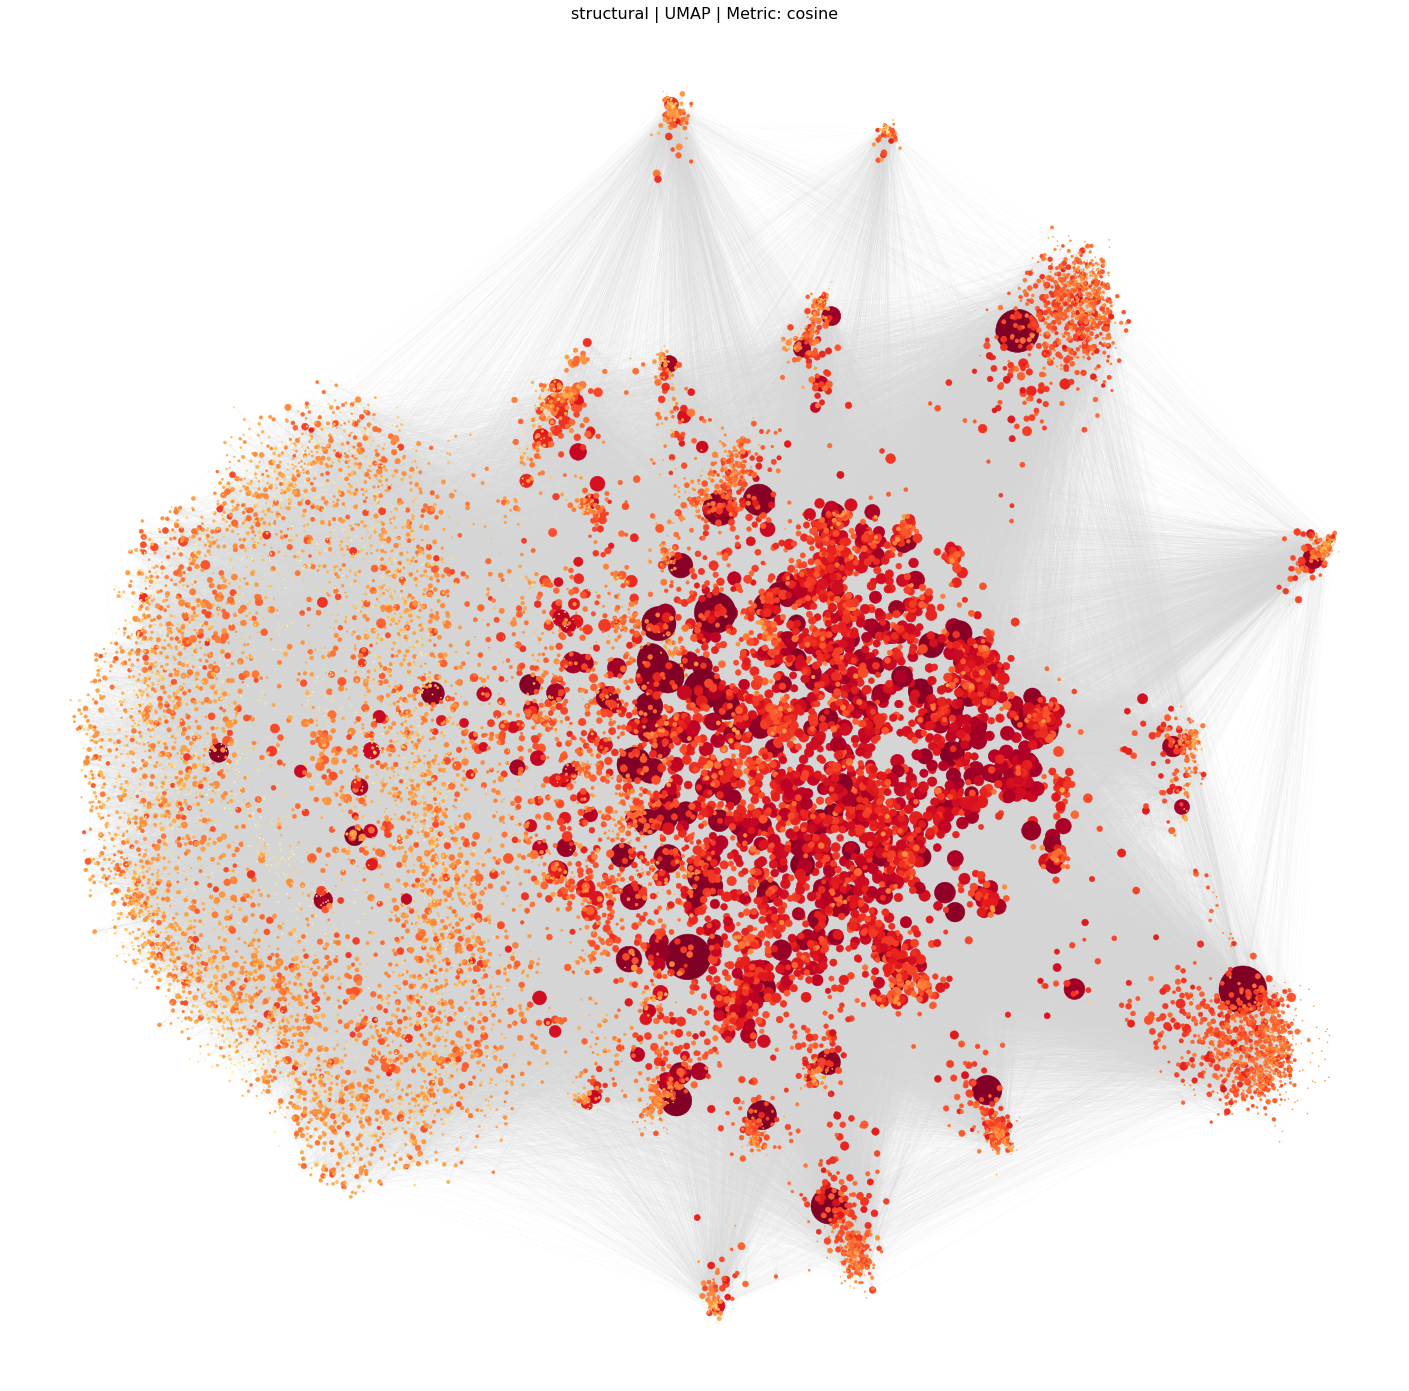

In [178]:
print('Functional Aij based on following biological Functions:', d_feat_toplist)
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_umap, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_umap, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2DPortraitumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

# UMAP 3D 

In [173]:
%%time 

umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 7min 27s, sys: 10.8 s, total: 7min 38s
Wall time: 6min 1s


In [174]:
# MAIN (if not all G.nodes)
posG_3Dumap = get_posG_3D(genes, umap_3D)
posG_3D_complete_umap = {key:posG_3Dumap[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_3D_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

In [175]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_colordark, opac=0.15)

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 4.99 s, sys: 88.9 ms, total: 5.07 s
Wall time: 5.11 s


In [176]:
print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    


# py.iplot(fig)
plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.html', auto_open=True)

# Neighbours: 20
Spread: 1.0
Min. Distance: 0.1


'output_plots/3Dportrait_umap_structural_cosine_clos_20_1.0_0.1_Human.html'